# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [8]:
# Import stuff.
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ast


# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [9]:
rules_data_path = 'data/rules.tsv.xz'

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,
                       converters={
                           'consequent_item': ast.literal_eval,
                           'antecedent_items': ast.literal_eval
                       },
                       low_memory=True)

But just *how* many rules were just loaded‽

In [10]:
# Show the list of column names and the number of rules.
df_rules


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
...,...,...,...,...,...,...
1048570,Apples and Plums Stage 2 Baby Food,3346083,190,3346083,190,[]
1048571,Apitherapy Raw Honey,3346083,190,3346083,190,[]
1048572,Antioxidant Super Tea Pomegranate Peach Passio...,3346083,190,3346083,190,[]
1048573,All Natural Sausage Fully Cooked - 6 CT,3346083,190,3346083,190,[]


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [11]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

df_rules = df_rules.assign(support = df_rules['item_set_count'] / df_rules['transaction_count'],
                           confidence = df_rules['item_set_count']/df_rules['antecedent_count'],
                           lift = (df_rules['item_set_count']* df_rules['transaction_count']) / 
                           (df_rules['antecedent_count'] * df_rules['consequent_count']))

The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*
Since the yogurts have a high lift, the consequent is more likely compared to the baseline probability. This means that yogurt is bought very often with other items. This could be for a variety of reasons, such as many food items being toppings for yogurt. Yogurt is also a very popular food in many different cultures. I am not sure if this is possible but perhaps each yogurt is being sold in small servings and so people can be buying a few at a time which can boost its probability within this model.

In [35]:
# Query the rule set if you have to to find out more.
#I was curious if there are unique spellings of yogurt so I compared two dataframes and came to the conclusion that there are
yog_df = df_rules[df_rules['consequent_item'].str.contains('yogurt', na= False, case= False)]
yogg = df_rules[df_rules['consequent_item'].str.contains('yog', na= False, case= False)]

unique = yogg[~yogg['consequent_item'].isin(yog_df['consequent_item'])]
unique_yog = unique['consequent_item'].tolist()

unique_yog
amount = str(len(yogg))
print('There are ' + amount + ' yogurts')
yogg_lift_avg = yogg['lift'].mean()
yogg_lift_max = yogg['lift'].max()
yogg_lift_min = yogg['lift'].min()
print(yogg_lift_avg)
print(yogg_lift_max)
print(yogg_lift_min)

There are 303985 yogurts
2521.689577943176
21465.598513719513
1.0


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [63]:
# Define df_rules_subset.

temp = ((df_rules['consequent_item'].str.contains('Hummus', case=False) | 
                    df_rules['antecedent_items'].str.contains('Hummus', case=False)) & 
                   ~(df_rules['consequent_item'].str.contains('Hummus', case=False) & 
                     df_rules['antecedent_items'].str.contains('Hummus', case=False)))
df_rules_subset = df_rules[temp]
df_rules_subset = df_rules_subset[df_rules_subset['antecedent_items'].str.len()==1]
df_rules_subset = df_rules_subset[(df_rules_subset['lift'] >= 5) & (df_rules_subset['lift'] <= 20)]
df_rules_subset

#I don't understand why only hummus is from consequent and none from the antecedent_items

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
416420,Original Hummus,3346083,345,1656,74172,[Organic White Pita Bread],0.000103,0.208333,9.398434
419119,Original Hummus,3346083,293,1434,74172,[Organic Whole Wheat Pita],0.000088,0.204324,9.217543
422178,Original Hummus,3346083,331,1655,74172,[Mini Whole Wheat Pita Bread],0.000099,0.200000,9.022496
440198,Original Hummus,3346083,3119,17333,74172,[Sea Salt Pita Chips],0.000932,0.179946,8.117800
463035,Original Hummus,3346083,151,933,74172,"[Lentil Chips, Himalayan Pink Salt]",0.000045,0.161844,7.301163
463988,Original Hummus,3346083,311,1929,74172,[Garbanzo Beans No Salt Added],0.000093,0.161223,7.273189
476420,Original Hummus,3346083,512,3333,74172,[Organic Whole Peeled Baby Carrots],0.000153,0.153615,6.929970
506520,Original Hummus,3346083,168,1208,74172,[Baba Ghannouge Eggplant Dip],0.000050,0.139073,6.273921
519416,Original Hummus,3346083,117,875,74172,[Sonoma Organic Wraps Multigrain Tortillas Wit...,0.000035,0.133714,6.032183
523791,Original Hummus,3346083,1544,11702,74172,[Pita Chips Simply Naked],0.000461,0.131943,5.952288


Build a network `graph_rules_subset` from the association rules subset.

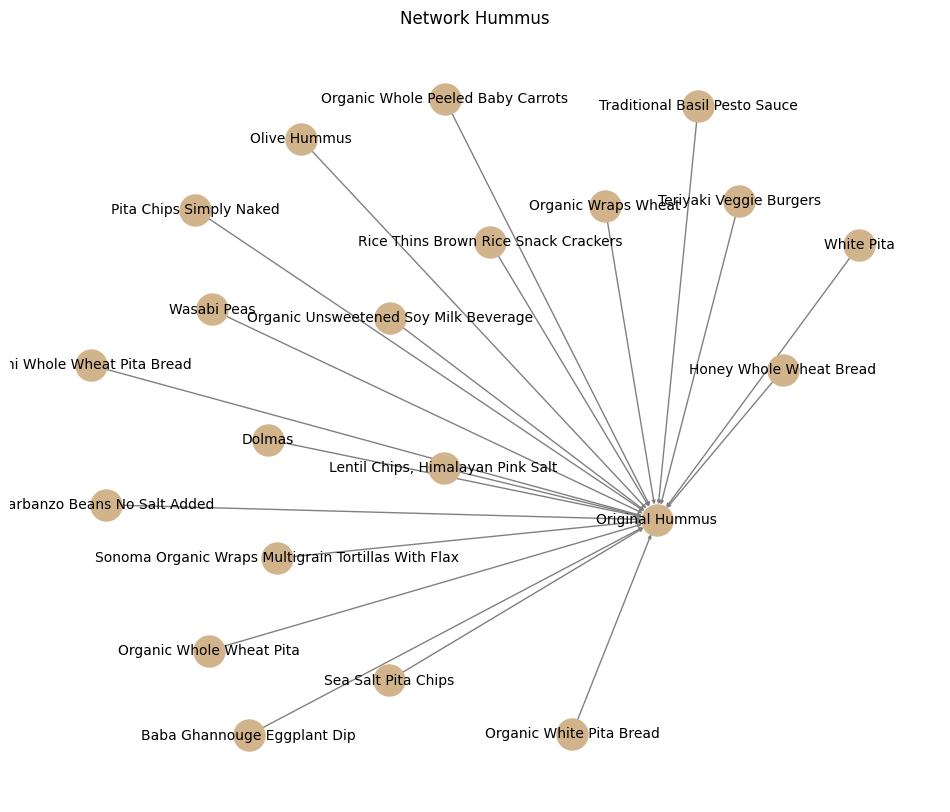

In [82]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()

graph_rules_subset.add_edges_from(
    (row['antecedent_items'][0], row['consequent_item']) for i, row in df_rules_subset.iterrows())

plt.figure(figsize=(12, 10))
plt.title('Network Hummus')


nx.draw(graph_rules_subset, with_labels=True, node_size=500, font_size=10, node_color='tan', 
        edge_color='gray', arrowsize=5)


What can you tell about people who buy hummus?

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [83]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

df_rules[df_rules['antecedent_items'].apply(lambda x: any(item in x for item in basket)) 
         ].sort_values('lift', ascending=False).head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
342462,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,100,209,19962,"[Nonfat Icelandic Style Strawberry Yogurt, Ora...",0.000030,0.478469,80.202217
345882,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,132,311,19962,"[Non Fat Raspberry Yogurt, Orange Bell Pepper]",0.000039,0.424437,71.145298
346832,Nonfat Icelandic Style Strawberry Yogurt,3346083,100,441,11025,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000030,0.226757,68.820769
346901,Non Fat Raspberry Yogurt,3346083,184,529,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000055,0.347826,68.651858
349532,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,184,494,19962,"[Non Fat Raspberry Yogurt, Organic Red Bell Pe...",0.000055,0.372470,62.434341
350852,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,167,471,19962,"[Organic Red Bell Pepper, Vanilla Skyr Nonfat ...",0.000050,0.354565,59.433078
350991,Non Fat Raspberry Yogurt,3346083,132,441,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000039,0.299320,59.077960
351360,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,101,291,19962,"[Nonfat Icelandic Style Strawberry Yogurt, Org...",0.000030,0.347079,58.178302
351433,Nonfat Icelandic Style Strawberry Yogurt,3346083,101,529,11025,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000030,0.190926,57.946047
351881,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,133,392,19962,"[Orange Bell Pepper, Vanilla Skyr Nonfat Yogurt]",0.000040,0.339286,56.871965


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.